In [1]:
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
import os 
from pathlib import Path
import re
import PIL
import cv2
import seaborn as sns 
import copy
import importlib

import spectral_util
importlib.reload(spectral_util)
from spectral_util import *

import fluorescence_util
importlib.reload(fluorescence_util)
from fluorescence_util import *


In [2]:
# 'board.xlsx'
# 'board_noFlux.xlsx'
# 'flux_20240925_184835.xlsx'
# 'flux-onBoard.xlsx'
# 'lead_noFlux.xlsx'

# srcbase = Path("./data/EEM_F-7000_2025-04-11/")
print(Path.cwd())
srcbase = Path("./data/EEM_F-7000_2025-05-29/")
dstdir = Path("./dst/eem/filter")

srcdata = [
    {
        "path": fpath,
        "sample": fpath.stem.split("_")[0],  # 'ABS_20250411' → 'ABS'
        "label": None
    }
    for fpath in srcbase.glob("*.xlsx")
]
srcdata

c:\Users\sawamoto24\sawamoto24\修士研究\microplastic


[{'path': WindowsPath('data/EEM_F-7000_2025-05-29/ABS.xlsx'),
  'sample': 'ABS',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/HDPE.xlsx'),
  'sample': 'HDPE',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/LDPE.xlsx'),
  'sample': 'LDPE',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PC.xlsx'),
  'sample': 'PC',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PET_20250529_150210.xlsx'),
  'sample': 'PET',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PMMA.xlsx'),
  'sample': 'PMMA',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PP.xlsx'),
  'sample': 'PP',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PS.xlsx'),
  'sample': 'PS',
  'label': None},
 {'path': WindowsPath('data/EEM_F-7000_2025-05-29/PVC.xlsx'),
  'sample': 'PVC',
  'label': None}]

EEM of "ABS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "HDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "LDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PET"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PMMA"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PP"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PVC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].


<Figure size 640x480 with 0 Axes>

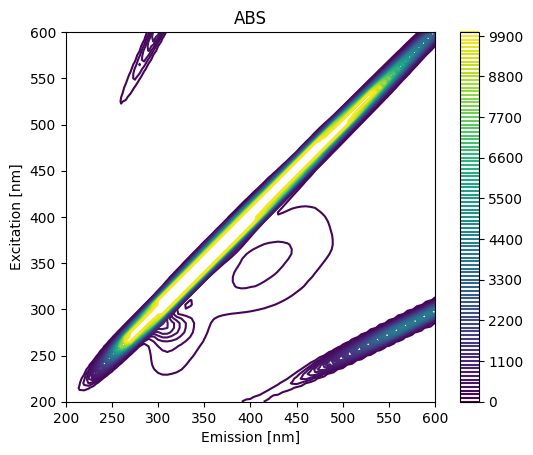

<Figure size 640x480 with 0 Axes>

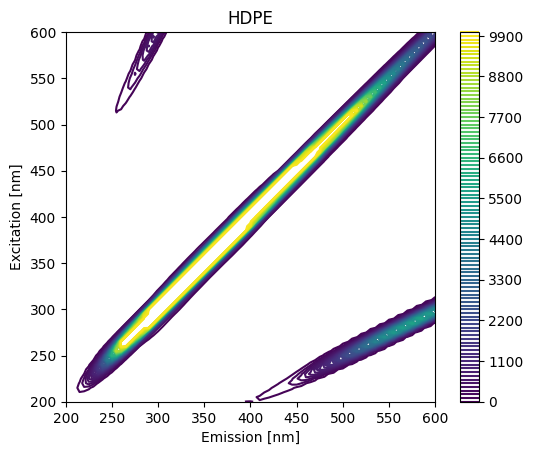

<Figure size 640x480 with 0 Axes>

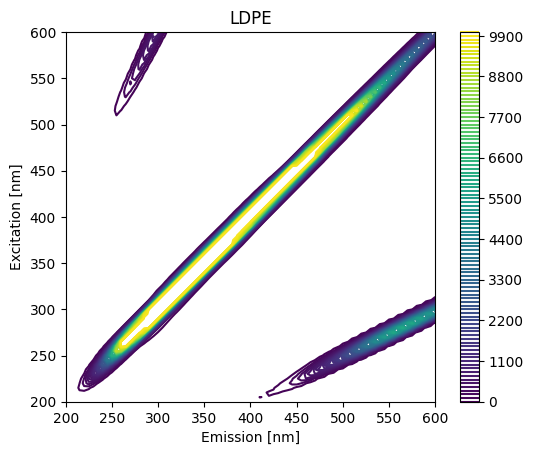

<Figure size 640x480 with 0 Axes>

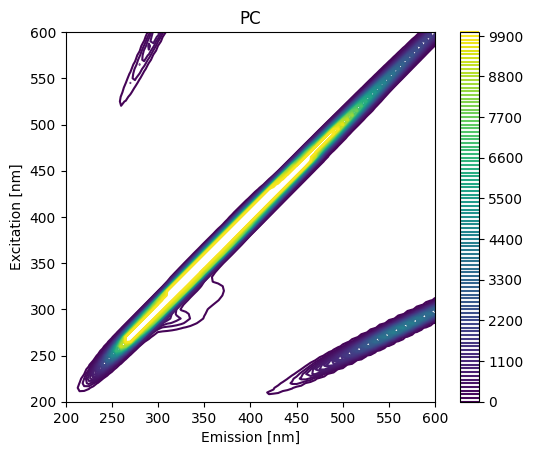

<Figure size 640x480 with 0 Axes>

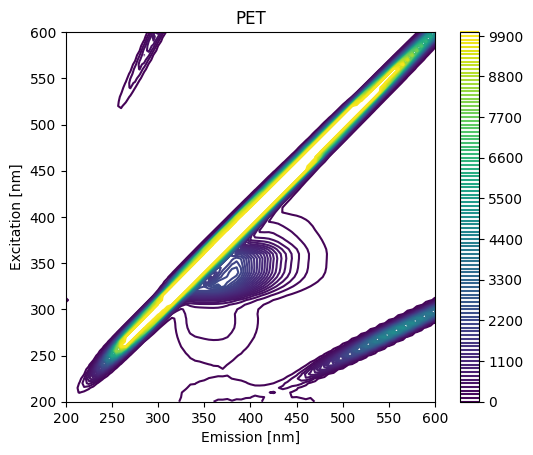

<Figure size 640x480 with 0 Axes>

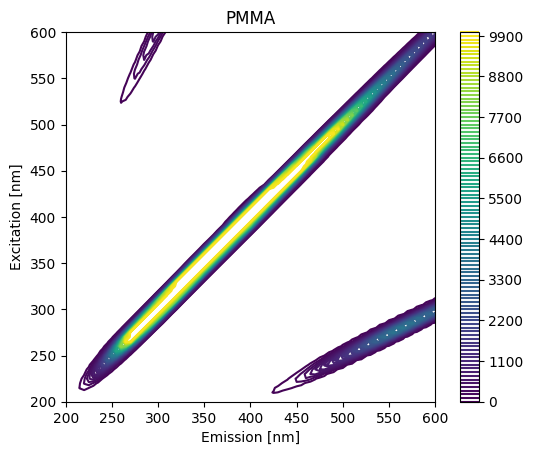

<Figure size 640x480 with 0 Axes>

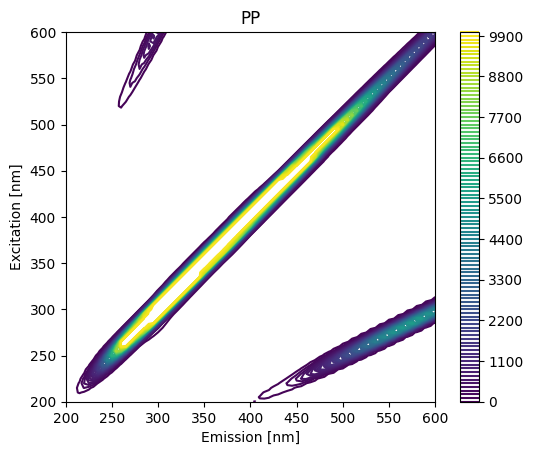

<Figure size 640x480 with 0 Axes>

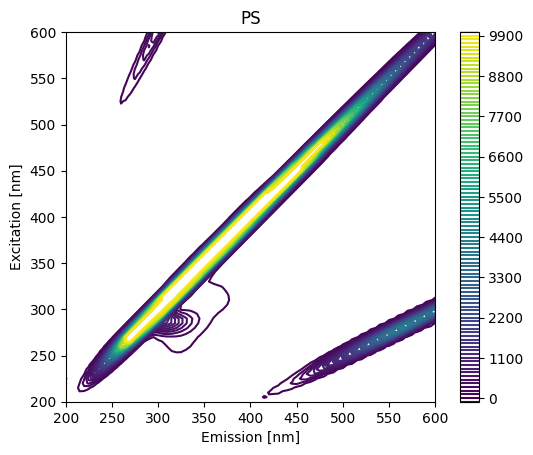

<Figure size 640x480 with 0 Axes>

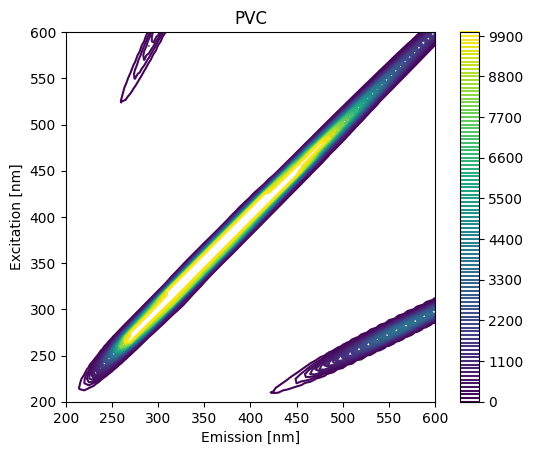

In [3]:
for data in srcdata:
    eem = fluorescence_util.EEMF7000(data.get('path'))
    print(eem)

    plt.figure()
    eem.plot_contour(level=100, show_sample_name=True)

In [4]:
em_bands = eem.em_bands
ex_bands = eem.ex_bands

EEMの1次反射・n次散乱光除去のためのスニペット (クラスメソッドに実装済み)

In [5]:
verbose = True
_df = copy.deepcopy(eem.eem_df)

def find_nearest(array: np.array, value):
    idx = (np.abs(array - value)).argmin()
    # val = array[idx]
    return int(idx)

def is_out_of_range(value, array: np.array = eem.ex_bands, step=eem.ex_band_step, verbose=False):
    if value+(step/2) < array.min():
        if verbose: print(f"{array.max()} < {value-(step/2)}") 
        return True
    elif array.max() < value-(step/2):
        if verbose: print(f"{array.max()} < {value-(step/2)}")
        return True
    
    return False

def _calc_shift_band(wl_src, degree=1, shift:int=0, band_step=eem.em_band_step):
    ''' eemのemissionの波長からexcitationの1次反射とn次散乱光の波長を計算する
    FIXME 後でGPTに埋めさせる
    :param wl_src: 
    :param degree:
    :param shift:
    :param band_step:

    :returns: 
    '''
    shifted_bands = wl_src * degree+(shift *band_step)

    return shifted_bands

def _elliminate_eem(eem_df, em, step, degree=1, bands_ex:np.array=eem.ex_bands, *, inplace=False, verbose=False):
    '''EEMにおける1次反射と2次散乱光を `np.nan` で埋めて消去する。
    FIXME 後でGPTに埋めさせる
    '''
    if not inplace:
        eem_df = eem_df.copy()

    wl_elim_ex = _calc_shift_band(em, shift= step, degree=degree)
    out_of_range = is_out_of_range(wl_elim_ex, verbose=verbose) 
    if verbose: 
        print(f"base={em} nm:/t({em}, {wl_elim_ex}), out-of-range={out_of_range}")
    idx_elim_ex = find_nearest(bands_ex, wl_elim_ex) # 最も近いexの波長を求める
    wl_elim_ex = bands_ex[idx_elim_ex]
    
    # 最近傍だと範囲を大きく超えていても最大値に張り付く可能性があるので 
    # (600nmの2次光の1200nmでも800nmがexの最大値なので800nmが削除対象に含まれている可能性がある) 
    # 範囲外の波長を除外する

    if em in eem.em_bands and wl_elim_ex in eem.ex_bands and not out_of_range:
        eem_df.loc[em, wl_elim_ex] = np.nan

    return eem_df

def remove_self_reflection_and_scattering_from_eem(eem_df, em_bands=eem.em_bands, margin_steps=3, *, inplace=False, verbose=False):
    if not inplace:
        eem_df = eem_df.copy()

    bands_targets = em_bands
    for target_em in bands_targets:

        for step in range(margin_steps):
            # 1次反射
            eem_df = _elliminate_eem(eem_df, em=target_em, step = -step, degree=1, inplace=inplace, verbose=verbose)
            eem_df = _elliminate_eem(eem_df, em=target_em, step = +step, degree=1, inplace=inplace, verbose=verbose)
            # 2次散乱
            eem_df = _elliminate_eem(eem_df, em=target_em, step = -step, degree=2, inplace=inplace, verbose=verbose)
            eem_df = _elliminate_eem(eem_df, em=target_em, step = +step, degree=2, inplace=inplace, verbose=verbose)
            # 3次散乱
            eem_df = _elliminate_eem(eem_df, em=target_em, step = -step, degree=3, inplace=inplace, verbose=verbose)
            eem_df = _elliminate_eem(eem_df, em=target_em, step = +step, degree=3, inplace=inplace, verbose=verbose)

    return eem_df


,200.0,205.0,210.0,215.0,220.0,225.0,230.0,235.0,240.0,245.0,...,555.0,560.0,565.0,570.0,575.0,580.0,585.0,590.0,595.0,600.0
em_bands,,,,,,,,,,,,,,,,,,,,,
200.0,NaN,NaN,NaN,NaN,NaN,NaN,2.002,1.684,2.577,3.253,...,7.851,8.019,7.521,8.396,NaN,NaN,NaN,NaN,NaN,NaN
205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.077,3.350,2.905,...,5.957,6.120,5.925,6.477,5.400,5.216,4.325,NaN,NaN,NaN
210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.821,3.428,...,5.960,5.482,5.841,5.051,5.017,5.220,4.614,5.057,4.252,4.189
215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.030,...,5.437,4.639,4.387,4.668,4.570,3.737,4.244,3.841,4.036,3.128
220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.802,4.064,4.132,3.557,3.602,3.008,3.347,2.678,2.587,2.653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580.0,0.075,0.076,0.090,0.068,0.107,0.076,0.084,0.082,0.084,0.105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585.0,0.085,0.080,0.073,0.072,0.095,0.071,0.094,0.071,0.082,0.109,...,0.695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590.0,0.090,0.073,0.097,0.085,0.086,0.100,0.103,0.081,0.114,0.133,...,0.527,0.559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


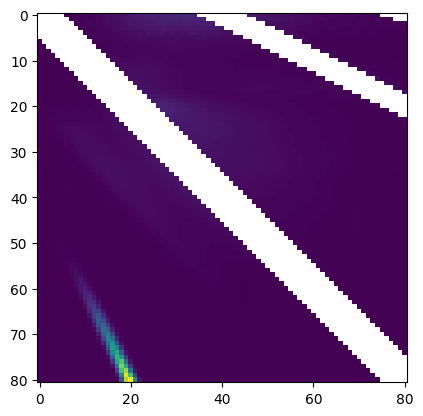

In [6]:
remove_self_reflection_and_scattering_from_eem(eem_df=_df, margin_steps=6, inplace=True)
plt.imshow(_df[eem.ex_bands].values)
# _df.values
_df[eem.ex_bands]

EEM of "ABS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "HDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "LDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PET"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PMMA"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PP"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
EEM of "PVC"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].


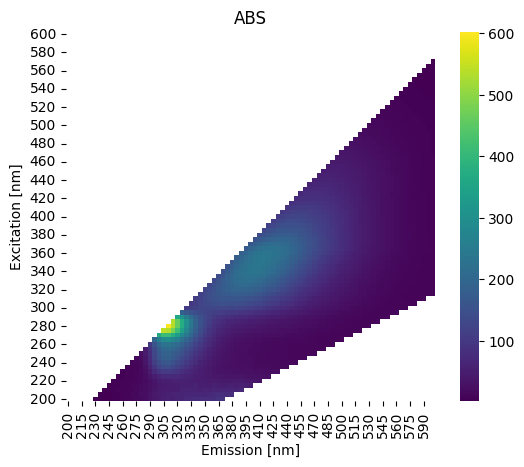

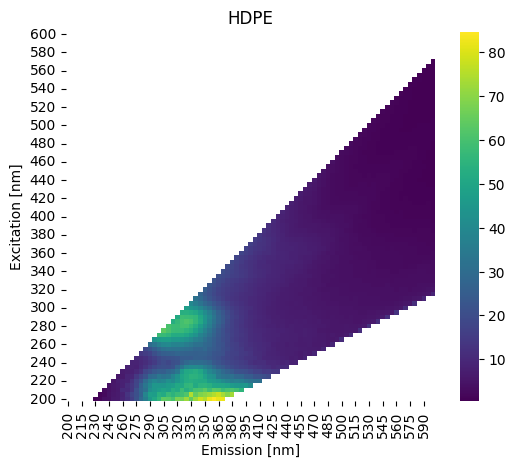

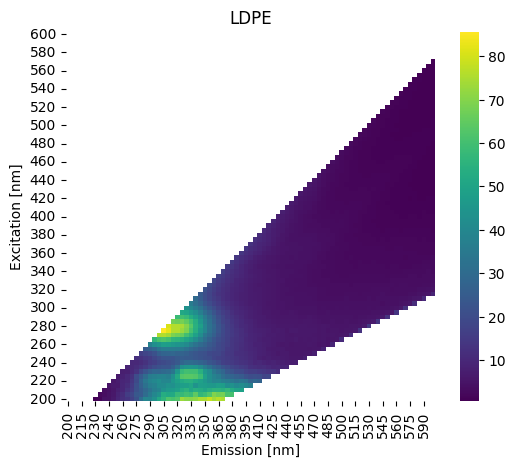

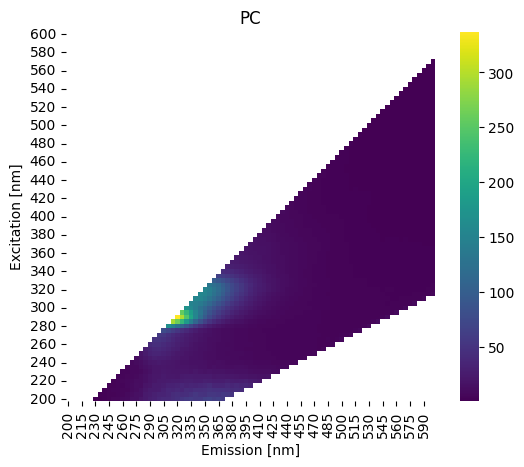

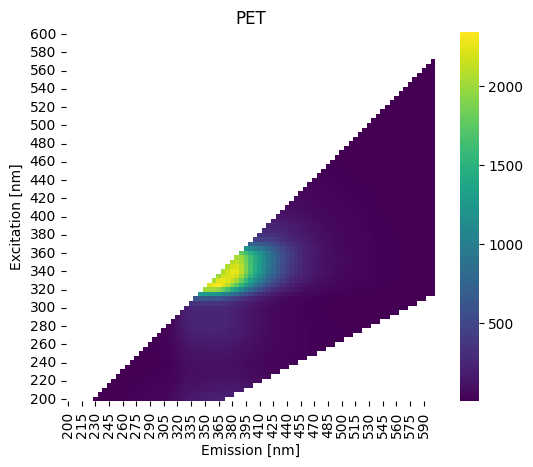

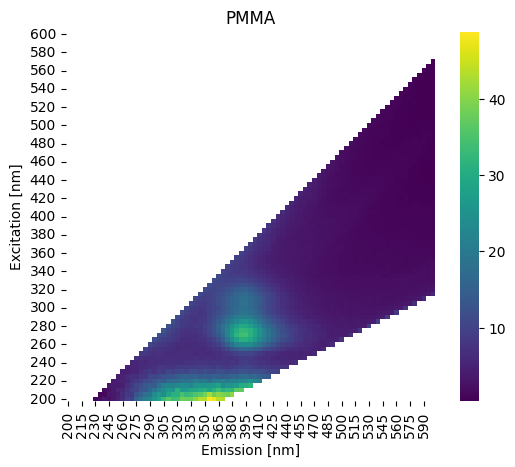

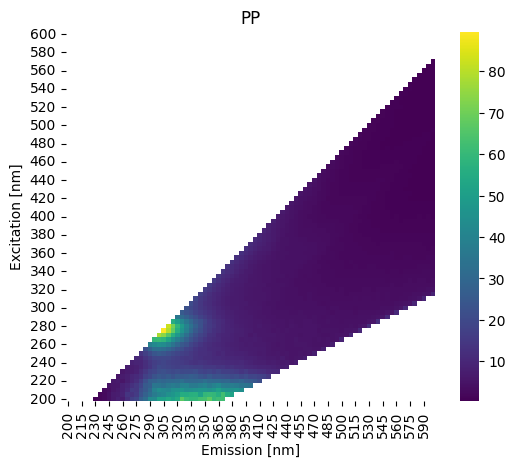

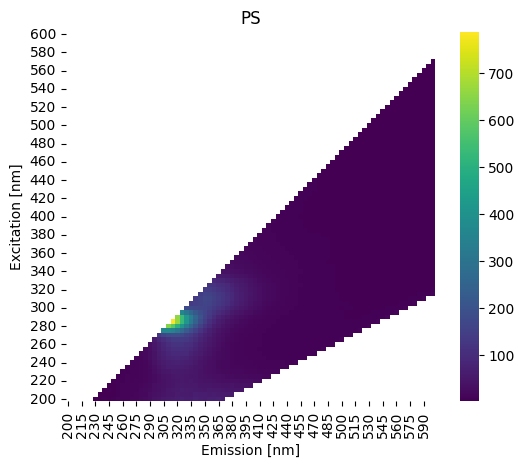

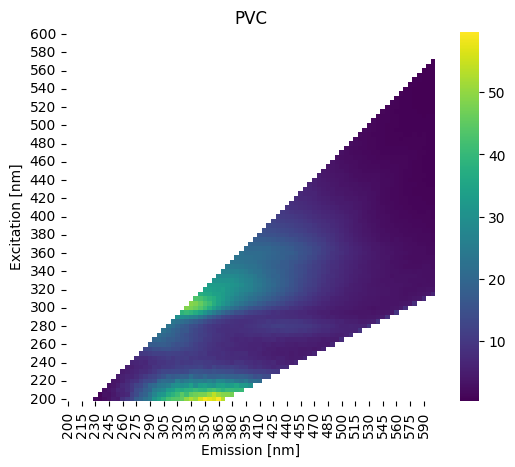

In [7]:
for data in srcdata:
    eem = fluorescence_util.EEMF7000(data.get('path'))
    print(eem)

    plt.figure()

    # ① 散乱ピーク除去
    eem.remove_self_reflection_and_scattering_from_eem(margin_steps=6,
                                                       remove_first_order=True, 
                                                       inplace=True)

    # ② 追加で散乱領域全体を除去
    eem.remove_scatter_regions(inplace=True)

    eem.plot_heatmap()
    plt.title(eem.sample)


EEM of "ABS"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
[[2.269e+01 2.529e+01 1.763e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.551e+01 3.649e+01 3.988e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [5.364e+00 2.795e+01 6.231e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [1.180e-01 1.250e-01 1.300e-01 ... 3.886e+03 2.288e+03 6.628e+02]
 [1.100e-01 1.010e-01 9.700e-02 ... 3.154e+03 3.519e+03 2.128e+03]
 [1.250e-01 1.030e-01 1.150e-01 ... 1.339e+03 2.918e+03 3.245e+03]]
EEM of "HDPE"-sample in Ex=[200.0--600.0nm of 5.0nm steps] and Em=[200.0--600.0nm of 5.0nm steps].
[[2.257e+01 2.490e+01 1.761e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.454e+01 3.590e+01 4.827e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [7.109e+00 2.494e+01 6.996e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [8.400e-02 1.000e-01 8.300e-02 ... 2.571e+03 1.490e+03 4.221e+02]
 [9.500e-02 8.300e-02 1.000e-01 ... 2.101e+03 2.335e+03 1.380e+03]
 [8.600e-02 1.220e-01 1.210e-01 ... 8.933e+02 1.926e+03

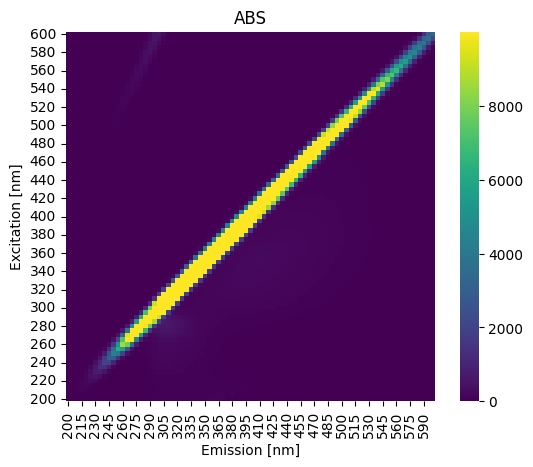

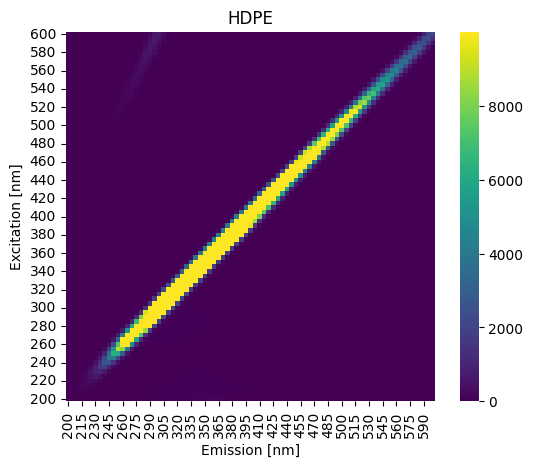

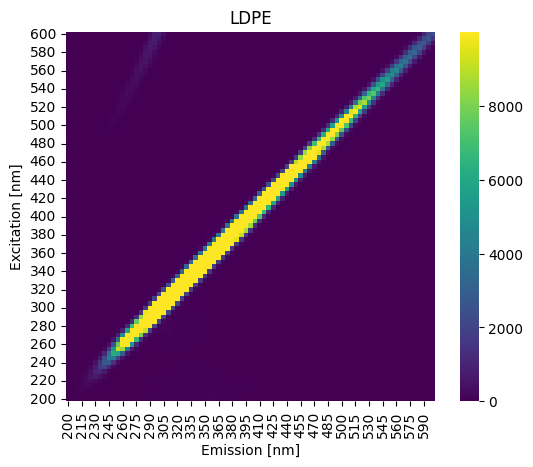

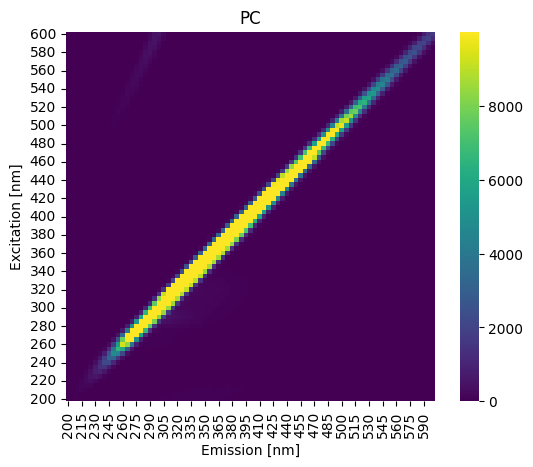

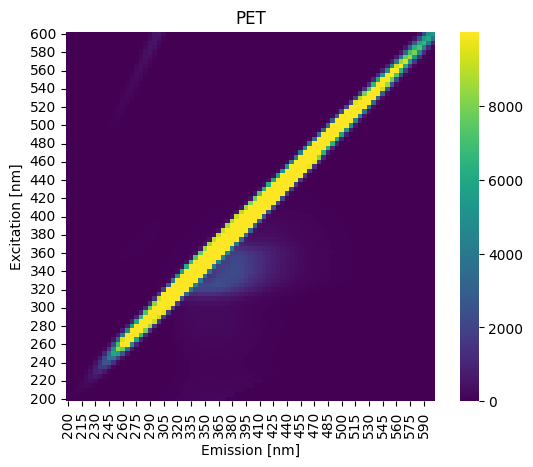

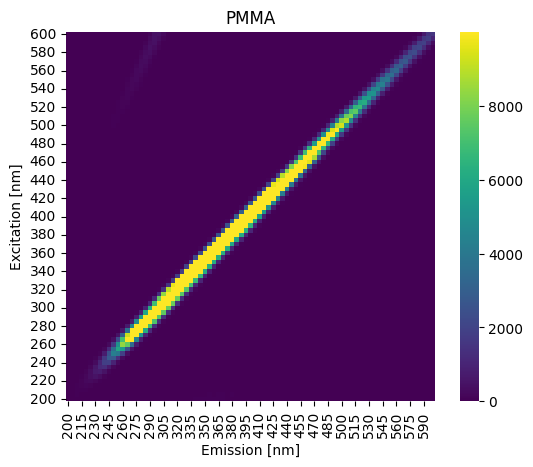

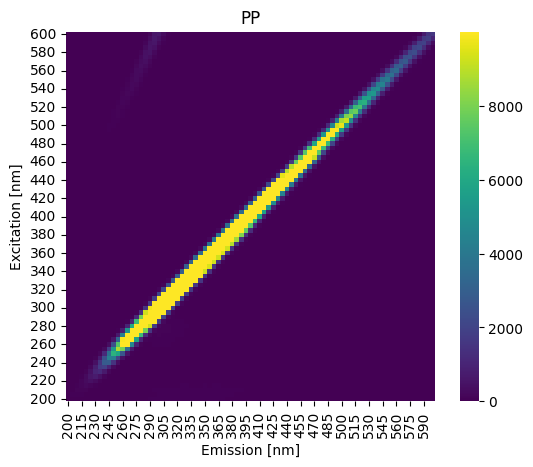

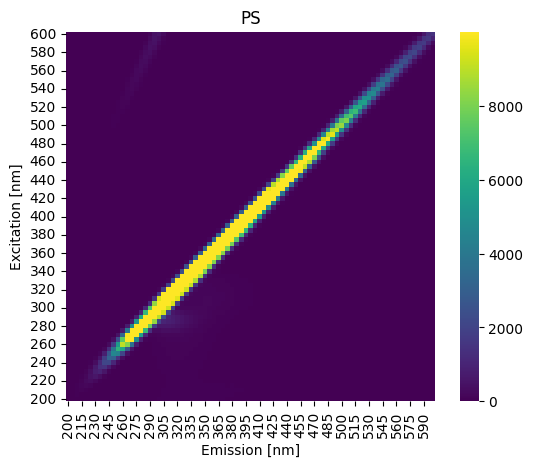

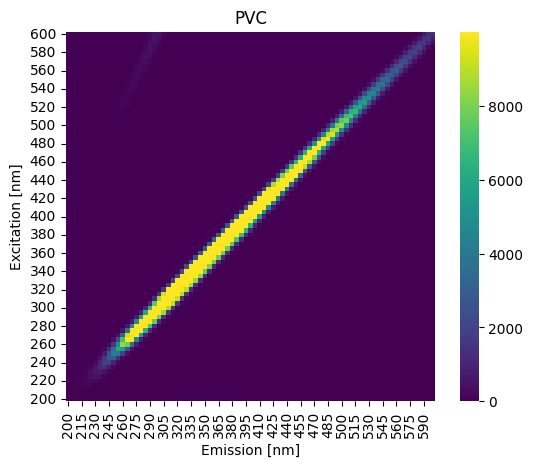

In [8]:
sample_data = []

for data in srcdata:

    eem = fluorescence_util.EEMF7000(data.get('path'))
    print(eem)

    plt.figure()

    # ①散乱ピーク除去
    eem.remove_self_reflection_and_scattering_from_eem(margin_steps=6,
                                                       remove_first_order=False,
                                                        inplace=True)

    # ②追加で散乱領域全体を除去
    eem.remove_scatter_regions_lowerright(inplace=True)

    # nan を 0 に置換
    eem.eem_df = eem.eem_df.fillna(0)

    eem.plot_heatmap()
    plt.title(eem.sample)


    eem_matrix = eem.mat  # numpy配列を取り出す
    eem_matrix = np.nan_to_num(eem_matrix, nan=0.0)  # nanを0に置換
    # サンプルごとにnumpy配列に追加
    sample_data.append(eem_matrix)

    print(eem_matrix)


# numpy配列に保存
eem_array = np.array(sample_data)

# [放射波長，励起波長，9種類]の形で保存
np.save('eem_data.npy', eem_array)

# 形状確認
print(f'EEM data shape: {eem_array.shape}')

---

# LED SPD

In [9]:
# _param_set = '200to600nm_narrow'
_param_set = '200to600nm_wide'
_params = {
    '200to600nm_narrow':{'wl_start': 200, 'wl_end': 600, 'band_steps': 10, 'band_resolution': 5, 'wl_FWHM': 10},
    '200to600nm_wide':  {'wl_start': 200, 'wl_end': 600, 'band_steps': 10, 'band_resolution': 5, 'wl_FWHM': 50},
    }
param = _params[_param_set]

_wl_bands = np.arange(param['wl_start'], param['wl_end'], param['band_steps'])
_df = pd.DataFrame({'wavelength':_wl_bands, })
_df.loc[:,_wl_bands] = 0

for wl in _wl_bands:
    _df.loc[_df.loc[:,'wavelength']==wl,wl] = 1

wl_sensor = _wl_bands


In [10]:
wl_FWHM = param['wl_FWHM']
var_FEHM = pow(wl_FWHM/2.35, 2)
f"σ={var_FEHM}, for {wl_FWHM} nm of FWHM"

'σ=452.69352648257126, for 50 nm of FWHM'

In [11]:
wl_start = param['wl_start']
wl_end = param['wl_end']
wl_res = param.get('band_resolution',5)
wl = np.array(range(wl_start, wl_end+1, wl_res))
wl_width = wl_end - wl_start
wl_bandstep = param['band_steps']
# wl_peeks = np.array(
#     range(wl_start+round(wl_bandstep/2), wl_end+1, wl_bandstep))
wl_peeks = np.array(range(wl_start, wl_end+1, wl_bandstep))
print("Range: {0}--{1}, ".format(wl_peeks[0],
      wl_peeks[-1]), "Band steps: {}".format(wl_bandstep))

label_wl = '{0}to{1}nm'.format(wl_start, wl_end, )

print(np.array(wl_peeks))
print('# of LEDs: {}'.format(len(wl_peeks)))


Range: 200--600,  Band steps: 10
[200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370
 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550
 560 570 580 590 600]
# of LEDs: 41


## Make SPD

In [12]:
spds_fill_ = np.array([
    np.exp(-pow(wl - wl_peek_, 2) / var_FEHM)
    for wl_peek_ in wl_peeks
    ])
spds_fill = spds_fill_.T
spds_fill.shape

(81, 41)

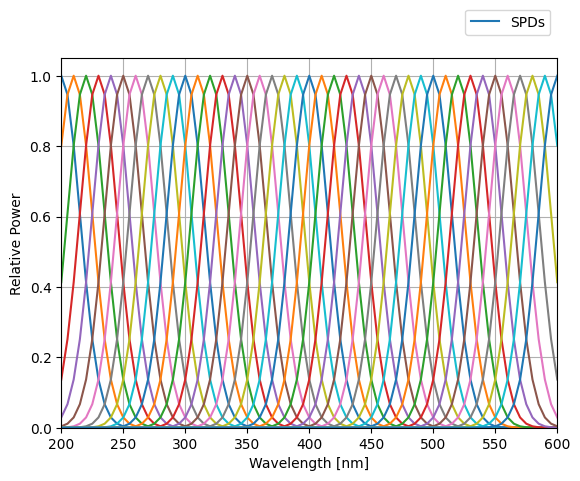

In [13]:
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
plt.plot(
    wl, spds_fill, label=[
    'SPDs'if i == 0 else '_nolegend_' for i in range(spds_fill.shape[1])])
plt.xlim([wl[0], wl[-1]])
plt.ylim([0, plt.ylim()[1]])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Power')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1.15))


C:\Users\sawamoto24\AppData\Local\Temp\ipykernel_10564\3322935088.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.0, 1.15))


array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,
       460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580,
       590, 600])

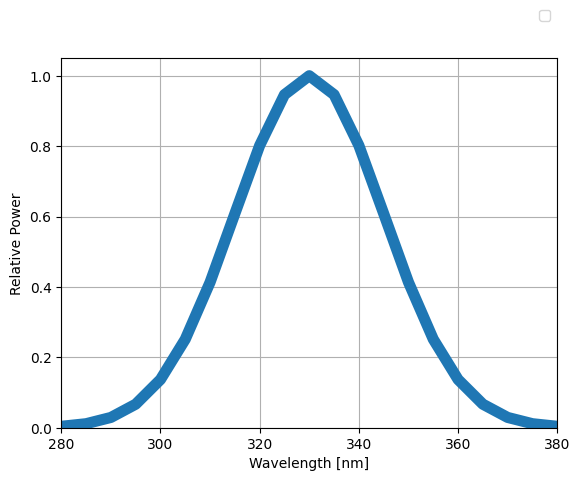

In [14]:
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
plt.plot(
    wl, spds_fill[:,13], label=[
    'SPDs'if i == 0 else '_nolegend_' for i in [7,]]
, linewidth = 8
    )
# plt.xlim([wl[0], wl[-1]])
plt.xlim([280, 380])
plt.ylim([0, plt.ylim()[1]])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Power')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1.15))

spds_fill.shape
wl_peeks

----

# camera sensitivity

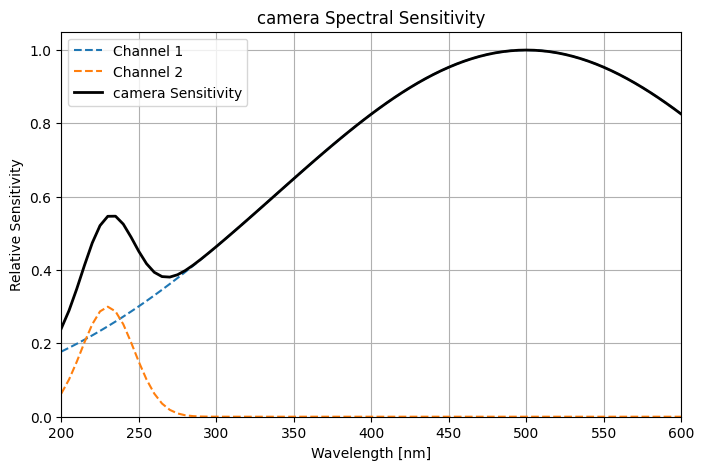

(81,)
(81, 2)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 波長範囲の設定（動的に変更可能）
wl_start = 200  # nm（変更したい開始波長）
wl_end = 600   # nm（変更したい終了波長）
wl_step = 5     # nm（分解能）

# 波長範囲の生成
wavelengths = np.arange(wl_start, wl_end + 1, wl_step)

# チャネルごとの設定
channels = [
    {"peak": 500, "fwhm": 380, "max_val": 1.0},
    {"peak": 230, "fwhm": 40, "max_val": 0.3}
]

# channels = [
#     {"name": "Red",   "peak": 600, "fwhm": 100, "max_val": 0.9},
#     {"name": "Green", "peak": 540, "fwhm": 90,  "max_val": 1.0},
#     {"name": "Blue",  "peak": 460, "fwhm": 80,  "max_val": 0.8}
# ]

# 感度行列（列ごとにチャネル）
sensitivity_all = []

for ch in channels:
    sigma = ch["fwhm"] / 2.355  # FWHMから標準偏差を計算
    sensitivity = np.exp(-0.5 * ((wavelengths - ch["peak"]) / sigma) ** 2)  # ガウス分布
    sensitivity /= np.max(sensitivity)  # 最大値で正規化
    sensitivity *= ch["max_val"]  # 最大感度値でスケーリング
    sensitivity_all.append(sensitivity)

# スタック（shape: (len(wl), 2)）
sensitivity_all = np.stack(sensitivity_all, axis=1)

# 合成：単純加算 → 正規化
camera_sensitivity = np.sum(sensitivity_all, axis=1)
camera_sensitivity /= np.max(camera_sensitivity)

# 描画
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, sensitivity_all[:, 0], label='Channel 1', linestyle='--')
plt.plot(wavelengths, sensitivity_all[:, 1], label='Channel 2', linestyle='--')
# plt.plot(wavelengths, sensitivity_all[:, 2], label='Channel 3', linestyle='--')
plt.plot(wavelengths, camera_sensitivity, label='camera Sensitivity', color='black', linewidth=2)
plt.title('camera Spectral Sensitivity')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Relative Sensitivity')
plt.grid(True)
plt.legend()
plt.xlim(wl_start, wl_end)  # 波長範囲を設定
plt.ylim(0, 1.05)
plt.show()

# 合成感度の形状を確認
print(camera_sensitivity.shape) # (波長（5step），)
print(sensitivity_all.shape) # (波長（5step），3チャンネル）
# wavelengths


---

# カメラ側にハイパスフィルタを適用

## カットオフ波長の計算

In [16]:
def generate_cutoff_list(peak_wavelengths, fwhm, margin_step, step):
    """
    各LEDに対応するハイパスフィルタのカットオフ波長を計算して返す。

    Parameters:
        peak_wavelengths (list or np.ndarray): 各LEDの中心波長
        fwhm (float): LEDのFWHM（半値幅）
        margin_step (float): 自己反射回避マージンのステップサイズ
        margin_num (int): ステップ数（margin_step × margin_numが追加マージン）

    Returns:
        list of float: 各LEDに対応したカットオフ波長（nm）
    """
    margin = margin_step * step
    cutoff_list = np.array([pw + fwhm + margin for pw in peak_wavelengths])
    
    return cutoff_list

cutoff_list = generate_cutoff_list(wl_peeks, fwhm=50, margin_step=6, step=0)
# cutoff_list の長さは spds_fillの列数と一致させる
if len(cutoff_list) != spds_fill.shape[1]:
    raise ValueError("cutoff_list length must match number of LEDs")

print(f"wl_peeks:{wl_peeks}")
print(f"cutoff_list:{cutoff_list}")



wl_peeks:[200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370
 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550
 560 570 580 590 600]
cutoff_list:[250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420
 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600
 610 620 630 640 650]


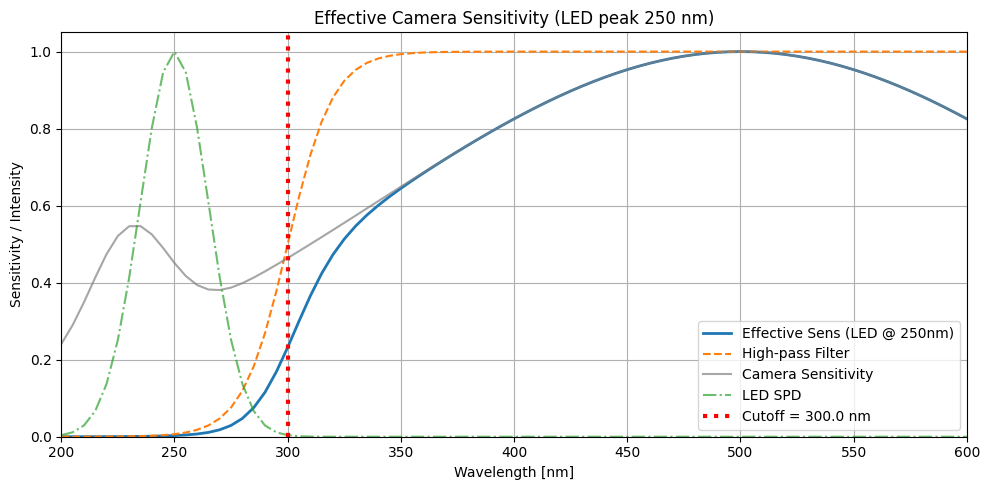

(81, 41)

In [17]:
def generate_hp_filter_matrix(wavelengths, cutoff_list, transition_width):
    hp_matrix = np.zeros((len(wavelengths), len(cutoff_list)))
    for i, cutoff in enumerate(cutoff_list):
        hp_matrix[:, i] = 1 / (1 + np.exp(-(wavelengths - cutoff) / transition_width))
    return hp_matrix

def plot_effective_camera_sens_by_peak(peak_wavelength, wl_peeks, wavelengths,
                                       camera_sensitivity, hp_filter_matrix, spds_fill,
                                       cutoff_list):
    """
    指定したLEDのピーク波長に対応するindexの有効カメラ感度をプロット。
    """
    idx = np.argmin(np.abs(np.array(wl_peeks) - peak_wavelength))
    cutoff = cutoff_list[idx]

    plt.figure(figsize=(10, 5))

    # 有効感度
    plt.plot(wavelengths, effective_camera_sens[:, idx], label=f'Effective Sens (LED @ {wl_peeks[idx]}nm)', linewidth=2)
    
    # ハイパスフィルタ
    plt.plot(wavelengths, hp_filter_matrix[:, idx], label='High-pass Filter', linestyle='dashed')
    
    # カメラ感度
    plt.plot(wavelengths, camera_sensitivity, label='Camera Sensitivity', color='gray', alpha=0.7)
    
    # LED SPD
    if spds_fill is not None:
        plt.plot(wavelengths, spds_fill[:, idx], label='LED SPD', linestyle='dashdot', alpha=0.7)

    # --- カットオフ波長の縦線 ---
    plt.axvline(cutoff, color='red', linestyle='dotted', linewidth=3, label=f'Cutoff = {cutoff:.1f} nm')
    
    plt.title(f'Effective Camera Sensitivity (LED peak {wl_peeks[idx]} nm)')
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Sensitivity / Intensity")
    plt.grid(True)
    plt.legend()
    plt.xlim(wavelengths[0], wavelengths[-1])
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

# 事前定義済みの変数:
# wavelengths, cutoff_list, camera_sensitivity, wl_peaks, spds_fill

# フィルタパラメータ
transition_width = 10  # nm
hp_filter_matrix = generate_hp_filter_matrix(wavelengths, cutoff_list, transition_width)
effective_camera_sens = camera_sensitivity[:, None] * hp_filter_matrix

# === 使用例 ===
plot_effective_camera_sens_by_peak(
    peak_wavelength=250,  # ここを任意で変える
    wl_peeks=wl_peeks,
    wavelengths=wavelengths,
    camera_sensitivity=camera_sensitivity,
    hp_filter_matrix=hp_filter_matrix,
    spds_fill=spds_fill,
    cutoff_list=cutoff_list
)

hp_filter_matrix.shape

---

# EEM × LED × カメラ感度

In [18]:
print(eem_array.shape)  # (10, 81, 81) = (サンプル数（MP），励起，放射)
print(spds_fill.shape)  # (81, 41) = (光強度（各励起波長），LEDの数)

# shapes: (10, 81, 81) @ (81, 41) → (10, 41, 81){(サンプル数（MP），LEDの数，放射（蛍光）)}　
eem_array = np.nan_to_num(eem_array)
fluorescence = np.einsum('sem,el->slm', eem_array, spds_fill)
print(fluorescence.shape) 



print(effective_camera_sens.shape)

# shapes: (10, 41, 81) @ (81, 41) → (10, 41)(サンプル数，LEDの数)
# 蛍光 × カメラ感度(with Filter) → カメラが感じる信号
camera_signals = np.einsum('slm,ml->sl', fluorescence, effective_camera_sens)
print(camera_signals.shape)


(9, 81, 81)
(81, 41)
(9, 41, 81)
(81, 41)
(9, 41)


Selected LED 8 with peak wavelength 280.0 nm


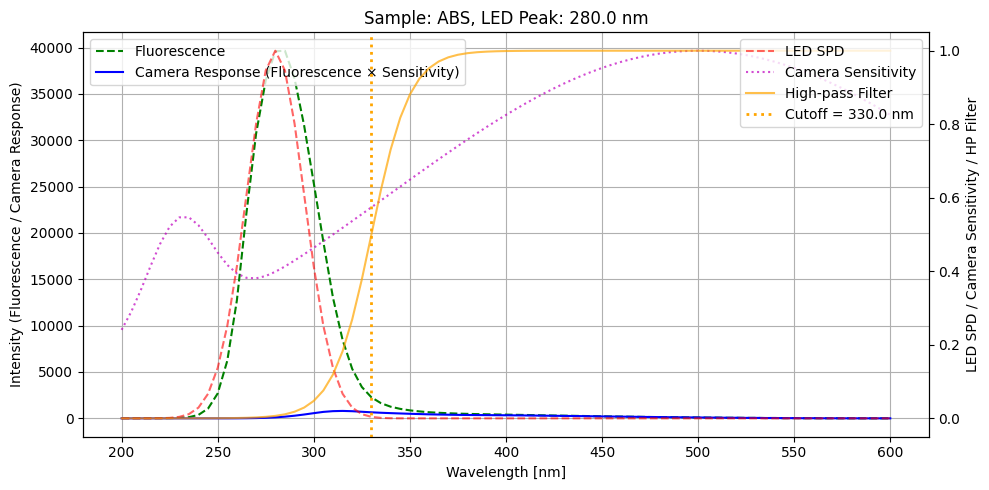

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# === サンプル名の取得 ===
sample_names = []
for data in srcdata:
    eem = fluorescence_util.EEMF7000(data.get('path'))
    sample_names.append(eem.sample)

# === 波長定義 ===
ex_wavelengths = np.linspace(200, 600, spds_fill.shape[0])  # 励起波長
em_wavelengths = np.linspace(200, 600, fluorescence.shape[2])  # 放射波長

# === 各LEDのピーク波長取得 ===
wl_peeks  = ex_wavelengths[np.argmax(spds_fill, axis=0)]

# === 任意指定（表示するサンプル・LED波長）===
sample_name = 'ABS'
sample_idx = sample_names.index(sample_name)
desired_peak_wavelength = 280
led_idx = np.argmin(np.abs(wl_peeks  - desired_peak_wavelength))
print(f"Selected LED {led_idx} with peak wavelength {wl_peeks [led_idx]:.1f} nm")

# === 該当サンプル・LEDの蛍光スペクトルとLED SPD・カメラ感度取得 ===
fluor = fluorescence[sample_idx, led_idx]  # shape: (81,)
led_spd = spds_fill[:, led_idx]           # shape: (81,)
cam_resp = fluor * effective_camera_sens[:, led_idx]     # 蛍光 × カメラ感度
cam_sens = camera_sensitivity             # shape: (81,)


# === ハイパスフィルタ情報 ===
hp_curve = hp_filter_matrix[:, led_idx]  # shape: (81,)
cutoff = cutoff_list[led_idx]

# === プロット ===
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左軸：蛍光スペクトル・カメラ応答
ax1.plot(em_wavelengths, fluor, label='Fluorescence', color='green', linestyle='--')
ax1.plot(em_wavelengths, cam_resp, label='Camera Response (Fluorescence × Sensitivity)', color='blue')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Intensity (Fluorescence / Camera Response)')
ax1.grid(True)
ax1.legend(loc='upper left')

# 右軸：LED SPD・カメラ感度・ハイパスフィルタ
ax2 = ax1.twinx()
ax2.plot(ex_wavelengths, led_spd, 'r--', alpha=0.6, label='LED SPD')
ax2.plot(em_wavelengths, cam_sens, 'm:', alpha=0.7, label='Camera Sensitivity')
ax2.plot(em_wavelengths, hp_curve, color='orange', linestyle='-', alpha=0.7, label='High-pass Filter')
ax2.axvline(cutoff, color='orange', linestyle='dotted', linewidth=2, label=f'Cutoff = {cutoff:.1f} nm')
ax2.set_ylabel('LED SPD / Camera Sensitivity / HP Filter')
ax2.legend(loc='upper right')

plt.title(f'Sample: {sample_name}, LED Peak: {wl_peeks [led_idx]:.1f} nm')
plt.tight_layout()
plt.show()


---

# カメラ出力空間plot

## 分光感度（複数センサチャネル）　× ハイパスフィルタ × 放射波長

In [20]:
print(fluorescence.shape)               # (10, 41, 81){(サンプル数（MP），LEDの数，放射（蛍光）)}
# print(sensitivity_all.shape)            # (81, 3) = (波長，RGBセンサチャネル)
print(hp_filter_matrix.shape)             # (81, 41) = (波長，LEDの数)

print(camera_sensitivity.shape)           # (81, ) = (波長，)　1センサチャネル モノクロカメラ


# # 複数チャネルの場合
# # 有効感度 = 分光感度 × フィルタ
# effective_sens = sensitivity_all[:, :, None] * hp_filter_matrix[:, None, :]
# print(effective_sens.shape)

# # それぞれのセンサチャネル応答 = 放射波長 × 有効感度
# # shapes: (10, 41, 81) @  → 
# camera_response = np.einsum('sle,lcr->slc', fluorescence, effective_sens.transpose(2,1,0))
# print(camera_response.shape)


# 単一チャネルの場合　
# 有効感度 = 分光感度　× フィルタ 
# (41, 81) * (81, ) = (41, 81)
effective_sens = hp_filter_matrix.T * camera_sensitivity  
print(effective_sens.shape)

# チャネル応答 = 放射波長 × 有効感度
# shapes: (10, 41, 81) @ (41, 81) → (10, 41) 10サンプル×41LEDのセンサ応答値
camera_response = np.einsum('sle,le->sl', fluorescence, effective_sens)
print(camera_response.shape)


(9, 41, 81)
(81, 41)
(81,)
(41, 81)
(9, 41)


## カメラ出力空間

In [21]:
import numpy as np
import plotly.graph_objs as go
import gradio as gr



def plot_sensor_response_2d(selected_peak):
    led_idx = int(np.argmin(np.abs(wl_peeks - selected_peak)))

    max_val = np.max(camera_response) * 1.1  # 応答値に応じたスケール固定

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=sample_names,
        y=camera_response[:, led_idx],
        text=[f"{v:.2f}" for v in camera_response[:, led_idx]],
        textposition='auto',
        marker_color='gray'
    ))

    fig.update_layout(
        title=f"センサ応答（励起波長 {wl_peeks[led_idx]:.0f} nm）",
        xaxis_title="サンプル",
        yaxis_title="応答値",
        width=500,
        height=400,
        bargap=0.1,
        xaxis=dict(tickangle=-45),
        yaxis=dict(range=[0, max_val])  # ← 固定スケール
    )

    return fig

peak_min = int(wl_peeks.min())
peak_max = int(wl_peeks.max())
step = int(np.min(np.diff(wl_peeks)))

iface = gr.Interface(
    fn=plot_sensor_response_2d,
    inputs=gr.Slider(minimum=peak_min, maximum=peak_max, step=step, label="励起波長 [nm]", interactive=True),
    outputs=gr.Plot(label="モノクロセンサ応答（バーグラフ）"),
    live=True,
    title="センサ応答の可視化"
)

iface.launch()


c:\Users\sawamoto24\sawamoto24\修士研究\microplastic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## 分離度

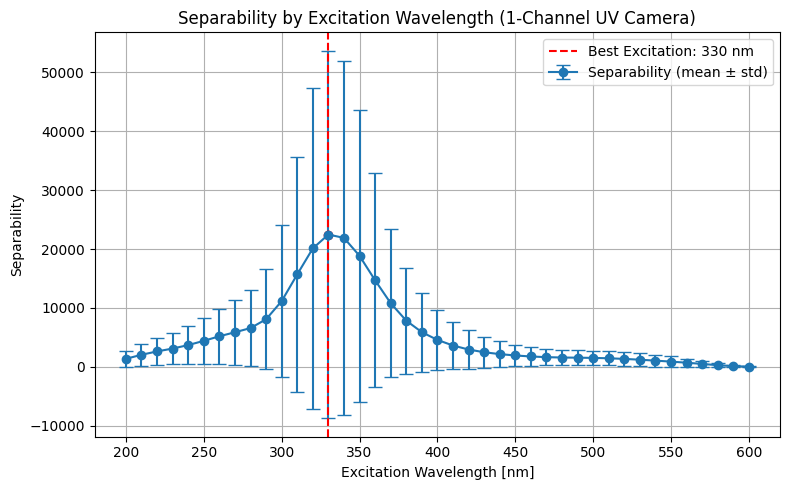

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

# 分離度の平均と標準偏差を格納するリスト
separability_means = []
separability_stds = []

# 各励起波長（列）について分離度（ユークリッド距離の平均）とばらつきを計算
for i in range(camera_response.shape[1]):
    responses = camera_response[:, i].reshape(-1, 1)  # shape: (samples, 1)
    distances = pdist(responses, metric='euclidean')  # 全組み合わせの距離
    separability_means.append(np.mean(distances))
    separability_stds.append(np.std(distances))      # 標準偏差を計算

separability_means = np.array(separability_means)
separability_stds = np.array(separability_stds)

# 最も識別に優れる波長
max_idx = np.argmax(separability_means)
best_wavelength = wl_peeks [max_idx]
best_score = separability_means[max_idx]

# プロット（平均値＋標準偏差のエラーバー付き）
plt.figure(figsize=(8, 5))
plt.errorbar(
    wl_peeks ,
    separability_means,
    yerr=separability_stds,
    fmt='-o',
    capsize=5,
    label='Separability (mean ± std)'
)
plt.axvline(best_wavelength, color='r', linestyle='--', label=f'Best Excitation: {best_wavelength:.0f} nm')
plt.scatter(best_wavelength, best_score, color='red')

plt.title('Separability by Excitation Wavelength (1-Channel UV Camera)')
plt.xlabel('Excitation Wavelength [nm]')
plt.ylabel('Separability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


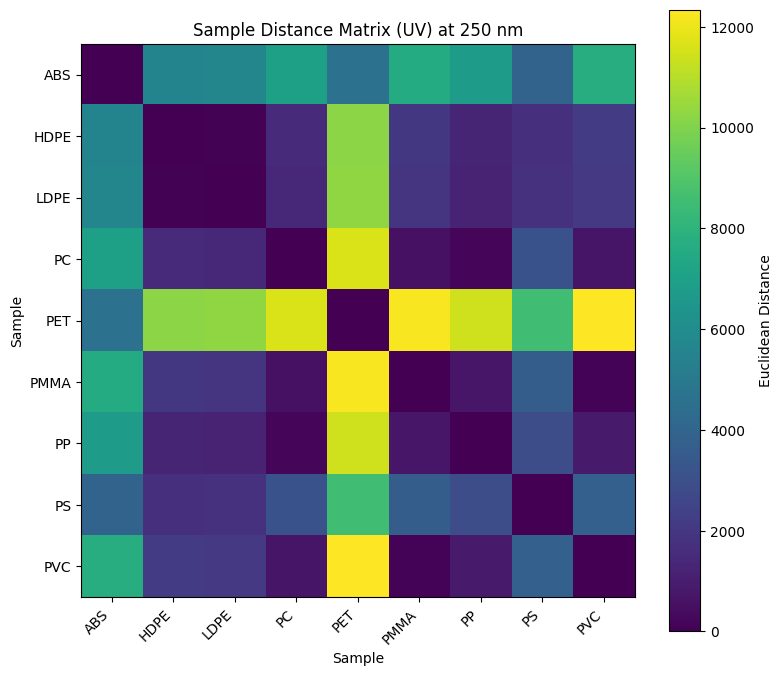

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist

def plot_distance_matrix_uv(selected_wavelength):
    # 波長に最も近いインデックスを探す
    i = np.argmin(np.abs(wl_peeks  - selected_wavelength))
    
    responses = camera_response[:, i].reshape(-1, 1)
    # responses_norm = (responses - np.mean(responses)) / np.std(responses)

    dist_vec = pdist(responses, metric='euclidean')
    # dist_vec = pdist(responses_norm, metric='euclidean')
    dist_mat = squareform(dist_vec)

    plt.figure(figsize=(8, 7))
    im = plt.imshow(dist_mat, cmap='viridis')
    plt.colorbar(im, label='Euclidean Distance')

    plt.title(f'Sample Distance Matrix (UV) at {wl_peeks [i]:.0f} nm')

    plt.xticks(ticks=np.arange(len(sample_names)), labels=sample_names, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(sample_names)), labels=sample_names)
    plt.xlabel('Sample')
    plt.ylabel('Sample')

    plt.tight_layout()
    plt.show()

# 使い方例
plot_distance_matrix_uv(250)  # 365nmでの距離行列を表示


In [24]:
np.max(camera_response
)

np.float64(89061.04596255599)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import gradio as gr
import io
from PIL import Image

# === 初期データ準備（ここは既にある前提で省略） ===
# srcdata, fluorescence_util, fluorescence, spds_fill,
# effective_camera_sens, camera_sensitivity,
# hp_filter_matrix, cutoff_list などの事前定義済み変数を前提

# --- サンプル名の取得 ---
sample_names = []
for data in srcdata:
    eem = fluorescence_util.EEMF7000(data.get('path'))
    sample_names.append(eem.sample)

# --- 波長定義とLEDピーク ---
ex_wavelengths = np.linspace(200, 600, spds_fill.shape[0])
em_wavelengths = np.linspace(200, 600, fluorescence.shape[2])
wl_peeks  = ex_wavelengths[np.argmax(spds_fill, axis=0)]


# === Plotlyバーグラフ関数 ===
def plot_sensor_response_2d(selected_peak):
    led_idx = int(np.argmin(np.abs(wl_peeks  - selected_peak)))
    max_val = np.max(camera_response) * 1.1

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=sample_names,
        y=camera_response[:, led_idx],
        text=[f"{v:.2f}" for v in camera_response[:, led_idx]],
        textposition='auto',
        marker_color='gray'
    ))

    fig.update_layout(
        title=f"センサ応答（励起波長 {wl_peeks [led_idx]:.0f} nm）",
        xaxis_title="サンプル",
        yaxis_title="応答値",
        width=500,
        height=400,
        bargap=0.1,
        xaxis=dict(tickangle=-45),
        yaxis=dict(range=[0, max_val])
    )
    return fig

# === matplotlibスペクトル図 ===
def plot_spectra(selected_sample, selected_peak):
    sample_idx = sample_names.index(selected_sample)
    led_idx = int(np.argmin(np.abs(wl_peeks  - selected_peak)))

    fluor = fluorescence[sample_idx, led_idx]
    led_spd = spds_fill[:, led_idx]
    cam_resp = fluor * effective_camera_sens[:, led_idx]
    cam_sens = camera_sensitivity
    hp_curve = hp_filter_matrix[:, led_idx]
    cutoff = cutoff_list[led_idx]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(em_wavelengths, fluor, label='Fluorescence', color='green', linestyle='--')
    ax1.plot(em_wavelengths, cam_resp, label='Camera Response (Fluor × Sens)', color='blue')
    ax1.set_xlabel('Wavelength [nm]')
    ax1.set_ylabel('Intensity (Fluorescence / Camera Response)')
    ax1.grid(True)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(ex_wavelengths, led_spd, 'r--', alpha=0.6, label='LED SPD')
    ax2.plot(em_wavelengths, cam_sens, 'm:', alpha=0.7, label='Camera Sensitivity')
    ax2.plot(em_wavelengths, hp_curve, color='orange', linestyle='-', alpha=0.7, label='High-pass Filter')
    ax2.axvline(cutoff, color='orange', linestyle='dotted', linewidth=2, label=f'Cutoff = {cutoff:.1f} nm')
    ax2.set_ylabel('LED SPD / Camera Sensitivity / HP Filter')
    ax2.legend(loc='upper right')

    plt.title(f'Sample: {selected_sample}, LED Peak: {wl_peeks [led_idx]:.1f} nm')
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

# --- 距離行列表示関数をGradio対応に改修 ---

def plot_distance_matrix_uv(selected_peak):
    i = int(np.argmin(np.abs(wl_peeks  - selected_peak)))
    responses = camera_response[:, i].reshape(-1, 1)

    dist_vec = pdist(responses, metric='euclidean')
    dist_mat = squareform(dist_vec)

    vmax = np.max(camera_response)
    # 下三角（対角含む）をマスク（Trueで隠す）
    mask = np.tril(np.ones_like(dist_mat, dtype=bool))

    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(dist_mat, mask=mask, cmap='viridis',
                xticklabels=sample_names, yticklabels=sample_names,
                vmin=0, vmax=vmax, square=True, cbar=True, ax=ax)

    ax.set_title(f'Sample Distance Matrix (UV) at {wl_peeks [i]:.0f} nm')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Sample')

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

def update_all(selected_sample, selected_peak):
    # Plotlyバーグラフ
    sensor_fig = plot_sensor_response_2d(selected_peak)
    # 蛍光スペクトル画像
    spectrum_img = plot_spectra(selected_sample, selected_peak)
    # 距離行列画像
    dist_img = plot_distance_matrix_uv(selected_peak)
    return sensor_fig, spectrum_img, dist_img

def build_ui():
    peak_min = int(wl_peeks .min())
    peak_max = int(wl_peeks .max())
    step = int(np.min(np.diff(wl_peeks )))

    with gr.Blocks() as demo:
        gr.Markdown("## 蛍光スペクトルとセンサ応答の可視化")

        with gr.Row():
            sample_dropdown = gr.Dropdown(choices=sample_names, value=sample_names[0], label="サンプル選択")
            peak_slider = gr.Slider(minimum=peak_min, maximum=peak_max, step=step,
                                    value=wl_peeks [0], label="励起波長 [nm]")

        with gr.Row():
            plotly_output = gr.Plot(label="センサ応答（バーグラフ）")
            image_output = gr.Image(label="スペクトル図", type="pil")

        with gr.Row():
            distance_matrix_output = gr.Image(label="距離行列（ユークリッド距離）", type="pil")

        # 両方の入力変更時にまとめて更新
        sample_dropdown.change(fn=update_all, inputs=[sample_dropdown, peak_slider],
                               outputs=[plotly_output, image_output, distance_matrix_output])
        peak_slider.change(fn=update_all, inputs=[sample_dropdown, peak_slider],
                           outputs=[plotly_output, image_output, distance_matrix_output])

    return demo

if __name__ == "__main__":
    demo = build_ui()
    demo.launch()



* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [26]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import gradio as gr
import io
from PIL import Image

# # グローバルスケール計算（初回のみ1回呼び出す想定）
# all_rgb_dists = np.array([
#     squareform(pdist(camera_rgb[:, i, :], metric="euclidean"))
#     for i in range(camera_rgb.shape[1])
# ])
# global_vmin = np.min(all_rgb_dists)
# global_vmax = np.max(all_rgb_dists)


# === Plotlyバーグラフ関数 ===
def plot_sensor_response_2d(selected_peak):
    led_idx = int(np.argmin(np.abs(wl_peeks  - selected_peak)))
    max_val = np.max(camera_response) * 1.1

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=sample_names,
        y=camera_response[:, led_idx],
        text=[f"{v:.2f}" for v in camera_response[:, led_idx]],
        textposition='auto',
        marker_color='gray'
    ))

    fig.update_layout(
        title=f"センサ応答（励起波長 {wl_peeks [led_idx]:.0f} nm）",
        xaxis_title="サンプル",
        yaxis_title="応答値",
        width=600,
        height=500,
        bargap=0.1,
        xaxis=dict(tickangle=-45),
        yaxis=dict(range=[0, max_val])
    )
    return fig

# 追加: 分離度プロット関数（励起波長スライダー連動）
def plot_separability(selected_peak):
    separability_means = []
    separability_stds = []
    for i in range(camera_response.shape[1]):
        responses = camera_response[:, i].reshape(-1, 1)
        distances = pdist(responses, metric='euclidean')
        separability_means.append(np.mean(distances))
        separability_stds.append(np.std(distances))
    separability_means = np.array(separability_means)
    separability_stds = np.array(separability_stds)

    max_idx = np.argmax(separability_means)
    best_wavelength = wl_peeks [max_idx]
    best_score = separability_means[max_idx]

    selected_idx = int(np.argmin(np.abs(wl_peeks  - selected_peak)))

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.errorbar(
        wl_peeks ,
        separability_means,
        yerr=separability_stds,
        fmt='-o',
        capsize=5,
        label='Separability (mean ± std)'
    )
    ax.axvline(best_wavelength, color='r', linestyle='--', label=f'Best Excitation: {best_wavelength:.0f} nm')
    ax.scatter(best_wavelength, best_score, color='red')
    ax.axvline(wl_peeks [selected_idx], color='blue', linestyle='-', linewidth=2, label=f'Selected: {wl_peeks [selected_idx]:.0f} nm')

    ax.set_title('Separability by Excitation Wavelength (1-Channel UV Camera)')
    ax.set_xlabel('Excitation Wavelength [nm]')
    ax.set_ylabel('Separability')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

# --- 距離行列表示関数をGradio対応に改修 ---

def plot_distance_matrix_uv(selected_peak):
    i = int(np.argmin(np.abs(wl_peeks  - selected_peak)))
    responses = camera_response[:, i].reshape(-1, 1)

    dist_vec = pdist(responses, metric='euclidean')
    dist_mat = squareform(dist_vec)


    vmax = np.max(camera_response)
    # 下三角（対角含む）をマスク（Trueで隠す）
    mask = np.tril(np.ones_like(dist_mat, dtype=bool))

    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(dist_mat, mask=mask, cmap='viridis',
                xticklabels=sample_names, yticklabels=sample_names,
                vmin=0, vmax=vmax, square=True, cbar=True, ax=ax)

    ax.set_title(f'Sample Distance Matrix (UV) at {wl_peeks [i]:.0f} nm')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Sample')

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

# update_allの戻り値を増やす
def update_all(selected_sample, selected_peak):
    sensor_fig = plot_sensor_response_2d(selected_peak)
    spectrum_img = plot_spectra(selected_sample, selected_peak)
    dist_img = plot_distance_matrix_uv(selected_peak)
    separability_img = plot_separability(selected_peak)  # 追加
    return sensor_fig, spectrum_img, dist_img, separability_img

def build_ui():
    peak_min = int(wl_peeks .min())
    peak_max = int(wl_peeks .max())
    step = int(np.min(np.diff(wl_peeks )))

    with gr.Blocks() as demo:
        gr.Markdown("## 蛍光スペクトルとセンサ応答の可視化")

        with gr.Row():
            sample_dropdown = gr.Dropdown(choices=sample_names, value=sample_names[0], label="サンプル選択")
            peak_slider = gr.Slider(minimum=peak_min, maximum=peak_max, step=step,
                                    value=wl_peeks [0], label="励起波長 [nm]")

        with gr.Row():
            plotly_output = gr.Plot(label="センサ応答（バーグラフ）")
            image_output = gr.Image(label="スペクトル図", type="pil")

        with gr.Row():
            distance_matrix_output = gr.Image(label="距離行列（ユークリッド距離）", type="pil")
            separability_output = gr.Image(label="励起波長別分離度プロット", type="pil")  # 横並びに変更


        # 出力を4つに増やし、対応させる
        sample_dropdown.change(fn=update_all, inputs=[sample_dropdown, peak_slider],
                               outputs=[plotly_output, image_output, distance_matrix_output, separability_output])
        peak_slider.change(fn=update_all, inputs=[sample_dropdown, peak_slider],
                           outputs=[plotly_output, image_output, distance_matrix_output, separability_output])

    return demo

if __name__ == "__main__":
    demo = build_ui()
    demo.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
